## Fact-check chatbot

First load all the API keys and choose an llm

In [1]:
import getpass
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama
import tqdm as notebook_tqdm

load_dotenv(dotenv_path=".env", override=True)

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="pr-left-technician-100"

llm = ChatOllama(model="qwen3:4b", temperature=0.2, base_url="http://localhost:11434")

c:\temp\checkmate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the Faiss database, and set up as retriever

In [2]:
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# Load existing FAISS index
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)
vectorstore = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

# Set up retriever
retriever = vectorstore.as_retriever()

Create a retriever tool, one that also checks the article behind the url, since only the url resides in the database. Furthermore the url's are seperated in ALLOWED URL's to ensure that the exact url is cited. This to prevent hallucinated url's.

In [4]:
from langchain.tools import tool
from newspaper import Article
import json

# ──────────────────────────────
# HELPER FUNCTION TO FETCH FULL ARTICLE CONTENT
# ──────────────────────────────
def fetch_full_article(url) -> tuple[str, bool]:
    """
    Fetch and return the full text of an article from a given URL.
    """
    try:
        article = Article(url)
        article.download()
        article.parse()
        return article.text, True
    except Exception as e:
        return f"[Failed to fetch article content from {url}: {e}]", False

#set a limit to the number of characters from the full article
max_chars = 1200

# ──────────────────────────────
# HELPER FUNCTION TO COMBINE SUMMARY AND FULL ARTICLE CONTENT, AND SEPERATE URLS
# ──────────────────────────────
def format_docs(docs) -> str:
    """
    Format the found documents to format
    """
    formatted = []
    for i, d in enumerate(docs, start=0):
        summary = (d.page_content or "").strip()
        url = d.metadata.get("url", "")
        full_content, page_exsists = fetch_full_article(url)
        
        #rerturn content only if the page exsists 
        if page_exsists:
            if len(full_content) > max_chars:
                full_content = full_content[:max_chars] + "…"
            combined = f"""
            [{i}] SUMMARY:
            {summary}

            [{i}] FULL ARTICLE CONTENT:
            {full_content}
            """
            formatted.append(combined)
        else:
            formatted.append(f"this url: {url} does not exist, don't use it in your answer")
    return "\n\n---\n\n".join(formatted)

@tool
# ──────────────────────────────
# TOOL FUNCTION  TO SEARCH FACTors DATASET, RETURN CONTEXT + ALLOWED_URLS
# ──────────────────────────────
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns information from the FACTors dataset.
    It returns two blocks as one string:
    1) CONTEXT: numbered snippets without URLs
    2) ALLOWED_URLS: a JSON dictionary of index -> url that the model must cite by index only
    """
    print(f"\n--retriever called, query: {query}--\n")
    docs = retriever.invoke(query)
    context_block = format_docs(docs)

    # Build a list of allowed URLs, and index them.
    urls = [d.metadata.get("url", "") for d in docs if d.metadata.get("url")]
    allowed = dict(enumerate(urls))
    print(f"Allowed URLs: {allowed}")

    # Return a single string so your existing tool plumbing still works.
    return (
        "CONTEXT (read-only; do NOT copy or invent URLs):\n"
        f"{context_block}\n\n"
        "ALLOWED_URLS (index -> url):\n"
        f"{json.dumps(allowed, indent=2)}\n\n"
        "INSTRUCTIONS: When citing, use indices from ALLOWED_URLS only (e.g., [0], [2]). "
        "Do not output raw URLs unless they come from ALLOWED_URLS."
    )

# Add the retriever tool to tools and bind the tool to the LLM
tools = [retriever_tool]
llm_tools = llm.bind_tools(tools)

# Creating a dictionary of our tools
tools_dict = {our_tool.name: our_tool for our_tool in tools} 
print(f"\n--{tools_dict}--\n")


--{'retriever_tool': StructuredTool(name='retriever_tool', description='This tool searches and returns information from the FACTors dataset.\nIt returns two blocks as one string:\n1) CONTEXT: numbered snippets without URLs\n2) ALLOWED_URLS: a JSON dictionary of index -> url that the model must cite by index only', args_schema=<class 'langchain_core.utils.pydantic.retriever_tool'>, func=<function retriever_tool at 0x00000185EE1E3CE0>)}--



The next part determines which data should be stored in AgentState (memory of the program), and how certain output should be structured using pydantic.

In [5]:
from typing import TypedDict, Annotated, Sequence, Literal, List
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from operator import add as add_messages

# Define the structure of a citation
class Citation(TypedDict):
    index: str
    url: str
    title: str
    passage: str

# Create an object to hold the state of the agent
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    claim: str
    checkable: bool
    verdict: Literal["true", "false", "mixed", "insufficient"]
    explanation: str
    citations: List[Citation]
    follow_up_Q: str


#output models for structured output
class Checkability(BaseModel):
    checkable: bool = Field(..., description="True if the claim is checkable, else false.")
    explanation: str = Field(..., min_length=1, description="Short justification for the decision.")

parser_checkability = PydanticOutputParser(pydantic_object=Checkability)
format_checkability = parser_checkability.get_format_instructions()

class FactCheckResult(BaseModel):
    verdict: Literal["TRUE", "FALSE", "MOSTLY TRUE", "MOSTLY FALSE","UNCHECKABLE"]
    explanation: str
    citations: List[Citation]

parser_fact_check = PydanticOutputParser(pydantic_object=FactCheckResult)
format_fact_check = parser_fact_check.get_format_instructions()

The functions of all the nodes

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage,AIMessage

# ──────────────────────────────
# NODE FUNCTION TO CHECK IF THE CLAIM is CHECKABLE
# ──────────────────────────────
def check_fact_checkability(state: AgentState) -> AgentState:
    """
    Check if a claim is checkable.
    """
    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(Checkability)

    # System prompt for checkability
    checkability_prompt = f"""
    Task:
    Decide if a single claim is CHECKABLE (factual, verifiable) or UNCHECKABLE (opinion, prediction, or too vague).

    Definitions:
    CHECKABLE: The claim asserts something that can be verified with evidence (e.g., data, records, studies), even without exact numbers or precise details.
    UNCHECKABLE: The claim is an opinion, value judgment, future prediction, or too vague to investigate.

    Rules:
    -Evidence link: If the claim refers to a measurable property or documentable fact, mark CHECKABLE. Lack of an exact figure does not disqualify it.
    -Comparisons: “More/less,” “higher/lower,” etc. are CHECKABLE if the attribute is measurable.
    -Clarity: If subject + attribute are specific enough that a journalist could look them up, it’s CHECKABLE. If too vague, UNCHECKABLE.
    -Future claims: Predictions are always UNCHECKABLE.
    -Value judgments: Normative or taste claims (“better,” “should,” “harmful”) are UNCHECKABLE, unless they define a measurable outcome.

    Examples:
    “Omicron spreads faster than other Covid-19 strains.” → CHECKABLE
    “Chocolate ice cream is better than vanilla.” → UNCHECKABLE
    “Unemployment was higher in 2023 than 2022.” → CHECKABLE
    “The stock market will crash next month.” → UNCHECKABLE
    “City X has more residents than City Y.” → CHECKABLE
    “This policy is harmful.” → UNCHECKABLE unless linked to specific metrics.

    {format_checkability}
    """
    msgs = [
        SystemMessage(content=checkability_prompt),
        HumanMessage(content=f'Claim: "{state["claim"]}"'),
    ]

    result: Checkability = structured_llm.invoke(msgs)

    # print output
    print("\n=== 1. CHECKABLE? ===")
    print(f"{result.checkable}")
    print(f"{result.explanation}")
    
    # Add the model's response as an AIMessage for traceability
    ai_msg = AIMessage(content=result.model_dump_json())
    
    return {
        **state,
        "checkable": result.checkable,
        "messages": list(state.get("messages", [])) + [ai_msg],
    }

# ─────────────────────────────
# CONDITIONAL FUNCTION: IF CHECKABLE -> CONTINUE
# ──────────────────────────────
def branch_on_checkable(state: AgentState) -> bool:
        return state.get("checkable")

# ─────────────────────────────
# NODE FUNCTION TO GATHER MORE EVIDENCE
# ──────────────────────────────
def research(state: AgentState) -> AgentState:
    """
    Call the tools iteratively (retriever tool) to gather evidence about the claim. 
    Add this evidence to the conversation history. 
    """
    claim = state.get("claim", "")

    # System prompt for research
    research_prompt = f"""
    INSTRUCTIONS
    - Call `retriever_tool` with short, focused queries directly about the {claim} (population, exposure, outcome, timeframe),
    or if the last HumanMessag is a "Follow up question" focus on this question.
    - Reformulate and call again ONLY if needed. Do not ask unrelated trivia.
    - Use retrieved CONTEXT and ALLOWED_URLS to decide if you need more queries.
    - Do NOT produce a final verdict or JSON in this turn.
    - When you have enough, stop calling tools and give a brief, ordinary reply (e.g., "Proceed to finalize").
    """
    msgs = [
        SystemMessage(content=research_prompt),
        HumanMessage(content="If you need evidence, call `retriever_tool` with a focused query, relevant to the claim.")
    ]
    messages = list(state.get("messages", [])) + msgs

    # Iteratively call tools until done, use llm_tools to enable tool calling
    while True:
        ai = llm_tools.invoke(messages) 
        print(f"AI Response: {ai.content}\n")
        messages.append(ai)

        # check if there are tool calls
        tc = getattr(ai, "tool_calls", None)
        if not tc:
            break

        # run tools and append ToolMessages
        tool_msgs = []
        for t in tc:
            out = tools_dict[t["name"]].invoke(t["args"].get("query", ""))
            tool_msgs.append(ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(out)))
        messages += tool_msgs

    return {**state, "messages": messages}

# ─────────────────────────────
# NODE FUNCTION TO STRUCTURE FINAL OUTPUT
# ──────────────────────────────
def finalize(state: AgentState) -> AgentState:
    """
    Finalize the fact-check by producing a verdict, explanation, and citations based on all retrieved evidence. 
    Use structured output to ensure the response is in the correct format.
    """
    claim = state.get("claim", "")

    # System prompt for finalization
    finalize_prompt = f"""
    You are finalizing a fact-check for the claim: "{claim}".

    You must rely ONLY on evidence already retrieved (CONTEXT and ALLOWED_URLS from prior tool calls in the conversation). 
    Do NOT call any tools now.

    VERDICTS
    - TRUE / FALSE/ MOSTLY TRUE / MOSTLY FALSE / UNCHECKABLE
    
    RULES
    - Match metric, population, geography, and timeframe.
    - Prefer primary/official sources; explain conflicts briefly.
    - Cite passages ≤40 words and reference sources by ALLOWED_URLS index only (e.g., "0", "2").
    - Include the urls from ALLOWED_URLS in your citations.

    {format_fact_check}
    """

    #use structured output to get a verdict eplanation and citations from ALLOWED_URLS
    structured_llm = llm.with_structured_output(FactCheckResult)

    msgs = list(state.get("messages", [])) + [
        SystemMessage(content=finalize_prompt),
        HumanMessage(content="Return ONLY the JSON for the final verdict based on retrieved evidence.")
    ]
    result: FactCheckResult = structured_llm.invoke(msgs)

    # print output
    print("\n=== 2. ANSWER ===")
    print(f"{result.verdict}")
    print(f"{result.explanation}")
    for citation in result.citations:
        print(f"[{citation['index']}] {citation['title']}")
        print(f"URL: {citation['url']}")
        print(f"Passage: {citation['passage']}\n")
   

    ai_msg = AIMessage(content=result.model_dump_json())
    return {
        **state,
        "verdict": result.verdict,
        "explanation": result.explanation,
        "citations": result.citations,
        "messages": list(state.get("messages", [])) + [ai_msg],
    }

# ─────────────────────────────
# CONDITIONAL FUNCTION: IF FOLLOW UP -> REPEAT FLOW
# ──────────────────────────────
def follow_up(state: AgentState) -> AgentState:
    """
    Check if the user has a follow-up question.
    """
    user_input = input("\nDo you have a follow-up question? (yes (y) /no (n)): ")

    if user_input == 'yes' or user_input == 'y':
        # if the user has a follow-up question, get the question and add it to the messages
        user_followup=input("\nWhat is your question? : ")
        return {
            **state,
            "follow_up_Q": user_followup,
            "messages": list(state.get("messages", [])) + [HumanMessage(content="follow up question: "+user_followup)],
        }       
    else:
        print("No follow-up question. Ending the fact-checking process.")
        return {**state,
                "follow_up_Q": None,
        }
    
    # ─────────────────────────────
# CONDITIONAL FUNCTION: IF FOLLOW-UP -> CONTINUE
# ──────────────────────────────
def branch_on_follow_up(state: AgentState) -> bool:
    if state.get("follow_up_Q")==None:
        return False
    else:
        return True

Create the langgraph nodes and edges, and visualize it

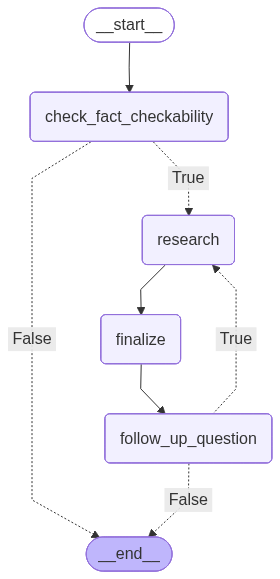

In [7]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(AgentState)
graph.add_node("check_fact_checkability", check_fact_checkability)
graph.add_node("research", research)          # tools handled internally (loop inside research)
graph.add_node("finalize", finalize)          # structured, no tools
graph.add_node("follow_up_question", follow_up)

# If checkable → research, else end
graph.add_conditional_edges(
    "check_fact_checkability",
    branch_on_checkable,
    {True: "research", False: END}
)

# After research, go finalize
graph.add_edge("research", "finalize")

# After finalize, offer follow-up
graph.add_edge("finalize", "follow_up_question")

# If user has a follow-up → back to research, else end
graph.add_conditional_edges(
    "follow_up_question",
    branch_on_follow_up,
    {True: "research", False: END}
)

# Entry point
graph.add_edge(START, "check_fact_checkability")

fact_bot = graph.compile()

#visualization
from IPython.display import Image, display
display(Image(fact_bot.get_graph().draw_mermaid_png()))

Run the agent in iterations, prompting the user everytime and log the conversation

In [8]:
from typing import List
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage

def running_agent():

    conversation_history: List[BaseMessage] = []
    while True:
        user_input = input("\nWhat claim do you want to investigate? ")
        if user_input.lower() in ['exit', 'quit']:
            break

        print(f"CLAIM: {user_input}")

        # Build full AgentState for this turn
        state: AgentState = {
            "messages": conversation_history + [HumanMessage(content=user_input)],
            "claim": user_input,
            "checkable": None, 
            "verdict": None,
            "explanation": None,
            "citations": None,
            "follow_up_Q": None,
        }

        # Invoke the compiled LangGraph app (your graph)
        result = fact_bot.invoke(state)

        # Update the rolling conversation history with everything the graph returned
        conversation_history = list(result["messages"])

        # Optional: react to checkability if you want to surface it explicitly
        if result.get("checkable") is False:
            print("\n(Stopped: claim judged UNCHECKABLE.)")

    # Persist a readable log
    with open("logging.txt", "w", encoding="utf-8") as f:
        f.write("Your Conversation Log:\n")
        for m in conversation_history:
            if isinstance(m, HumanMessage):
                f.write(f"You: {m.content}\n")
            elif isinstance(m, AIMessage):
                f.write(f"AI: {m.content}\n\n")
        f.write("End of Conversation\n")

    print("Conversation saved to logging.txt")

# run it
running_agent()


CLAIM: Deloitte Belgium claims to have reduced its CO2-emissions by a third in three years

=== 1. CHECKABLE? ===
True
The claim refers to a measurable reduction (a third) of CO2 emissions by a specific entity (Deloitte Belgium). While the exact percentage or source isn't specified, the attribute 'reduced by a third' is a quantifiable measure, and the subject is specific enough for verification through available data or reports.
AI Response: 


--retriever called, query: Deloitte Belgium CO2 emissions reduction 2023--

Allowed URLs: {0: 'https://science.feedback.org/review/diesel-cars-are-a-major-source-of-no2-emissions-in-european-cities-contrary-to-online-claim/', 1: 'https://mythdetector.com/en/are-global-leaders-planning-to-introduce-an-annual-carbon-limit/', 2: 'https://www.aap.com.au/factcheck/will-cutting-emissions-create-250000-jobs-in-a-decade/', 3: 'https://fullfact.org/economy/boris-johnson-economic-growth/'}
AI Response: 


--retriever called, query: Deloitte Belgium CO2 em

In [1]:
import sys, torch, pkgutil, platform
print("exe:", sys.executable)
print("python:", platform.python_version())
print("torch:", torch.__version__)
print("built with CUDA:", torch.version.cuda)      # None means CPU wheel
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
print("visible devices:", __import__("os").environ.get("CUDA_VISIBLE_DEVICES"))


exe: c:\temp\checkmate\.venv\Scripts\python.exe
python: 3.12.4
torch: 2.4.1+cu124
built with CUDA: 12.4
cuda available: True
device count: 1
visible devices: None
